In [1]:
#!pip install tensorflow google-cloud-aiplatform

In [4]:
#from google.colab import auth
#auth.authenticate_user()

PROJECT_ID = "rhic-innovation"
REGION = "us-central1"
BUCKET_NAME = PROJECT_ID

!gcloud config set project {PROJECT_ID}

Updated property [core/project].


In [5]:
train_dir = "gs://rhic-innovation/datasets/Brain tumor dataset/Training"
val_dir = "gs://rhic-innovation/datasets/Brain tumor dataset/Testing"

In [8]:
import os
import subprocess
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# GCS bucket and directory
local_directory = 'brain_tumor'
local_directory_train = 'brain_tumor/Training'  # Replace with the desired local directory
local_directory_val = 'brain_tumor/Testing'
# Ensure the local directory exists
os.makedirs(local_directory_train, exist_ok=True)

# Construct the GCS path
train_gcs_path = train_dir
val_gcs_path = val_dir



In [ ]:
# Use gsutil to download the data recursively
subprocess.run(['gsutil', '-m', 'cp', '-r', train_gcs_path, local_directory], check=True)
subprocess.run(['gsutil', '-m', 'cp', '-r', val_gcs_path, local_directory], check=True)

In [9]:
# Define image size and batch size
img_height, img_width = 200,200
batch_size = 32


# Data augmentation and normalization for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescaling for validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Load data from directories
train_generator = train_datagen.flow_from_directory(
    local_directory_train,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    local_directory_val,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4003 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [74]:
# Build a CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(4, activation='softmax')  # 4 classes as specified
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/home/jupyter/.local/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 46, 46, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 67712)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     8,667,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,769,028 (33.45 MB)

 Trainable params: 8,769,028 (33.45 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
import datetime

# Define callbacks
checkpoint_path = os.path.join(BUCKET_NAME, 'models/checkpoints/model-{epoch:02d}-{val_accuracy:.4f}.h5')
tensorboard_path = os.path.join(BUCKET_NAME, 'logs', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    tf.keras.callbacks.TensorBoard(log_dir=tensorboard_path, histogram_freq=1),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
]

# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks
)


/home/jupyter/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.3924 - loss: 1.2049
Epoch 1: val_accuracy improved from -inf to 0.51411, saving model to rhic-innovation/models/checkpoints/model-01-0.5141.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 55s 427ms/step - accuracy: 0.3931 - loss: 1.2040 - val_accuracy: 0.5141 - val_loss: 1.0431
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.5882 - loss: 0.9002
Epoch 2: val_accuracy improved from 0.51411 to 0.58963, saving model to rhic-innovation/models/checkpoints/model-02-0.5896.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 54s 425ms/step - accuracy: 0.5883 - loss: 0.9002 - val_accuracy: 0.5896 - val_loss: 0.9817
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.6365 - loss: 0.8427
Epoch 3: val_accuracy improved from 0.58963 to 0.68955, saving model to rhic-innovation/models/checkpoints/model-03-0.6895.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 54s 425ms/step - accuracy: 0.6366 - loss: 0.8425 - val_accuracy: 0.6895 - val_loss: 0.7338
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.6657 - loss: 0.7980
Epoch 4: val_accuracy improved from 0.68955 to 0.72845, saving model to rhic-innovation/models/checkpoints/model-04-0.7285.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 54s 425ms/step - accuracy: 0.6658 - loss: 0.7979 - val_accuracy: 0.7285 - val_loss: 0.6509
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.6968 - loss: 0.7315
Epoch 5: val_accuracy did not improve from 0.72845
126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 423ms/step - accuracy: 0.6969 - loss: 0.7314 - val_accuracy: 0.6583 - val_loss: 0.8425
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.7175 - loss: 0.6871
Epoch 6: val_accuracy improved from 0.72845 to 0.73227, saving model to rhic-innovation/models/checkpoints/model-06-0.7323.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 54s 424ms/step - accuracy: 0.7175 - loss: 0.6870 - val_accuracy: 0.7323 - val_loss: 0.6612
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.7323 - loss: 0.6815
Epoch 7: val_accuracy improved from 0.73227 to 0.74752, saving model to rhic-innovation/models/checkpoints/model-07-0.7475.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 54s 424ms/step - accuracy: 0.7322 - loss: 0.6815 - val_accuracy: 0.7475 - val_loss: 0.6087
Epoch 8/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.7453 - loss: 0.6314
Epoch 8: val_accuracy did not improve from 0.74752
126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 420ms/step - accuracy: 0.7453 - loss: 0.6313 - val_accuracy: 0.7140 - val_loss: 0.6970
Epoch 9/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.7408 - loss: 0.6282
Epoch 9: val_accuracy improved from 0.74752 to 0.75133, saving model to rhic-innovation/models/checkpoints/model-09-0.7513.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 423ms/step - accuracy: 0.7409 - loss: 0.6281 - val_accuracy: 0.7513 - val_loss: 0.6164
Epoch 10/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.7553 - loss: 0.5895
Epoch 10: val_accuracy did not improve from 0.75133
126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 422ms/step - accuracy: 0.7554 - loss: 0.5895 - val_accuracy: 0.7361 - val_loss: 0.6845
Epoch 11/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.7741 - loss: 0.5645
Epoch 11: val_accuracy did not improve from 0.75133
126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 423ms/step - accuracy: 0.7741 - loss: 0.5645 - val_accuracy: 0.6705 - val_loss: 0.7894
Epoch 12/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.7665 - loss: 0.5546
Epoch 12: val_accuracy did not improve from 0.75133
126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 420ms/step - accuracy: 0.7665 - loss: 0.5546 - val_accuracy: 0.7391 - val_loss: 0.7004
Epoch 13/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.7854 - loss: 0.5368
Epoch 13

126/126 ━━━━━━━━━━━━━━━━━━━━ 54s 425ms/step - accuracy: 0.7854 - loss: 0.5368 - val_accuracy: 0.7696 - val_loss: 0.5731
Epoch 14/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.7918 - loss: 0.5229
Epoch 14: val_accuracy improved from 0.76964 to 0.78032, saving model to rhic-innovation/models/checkpoints/model-14-0.7803.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 54s 427ms/step - accuracy: 0.7917 - loss: 0.5230 - val_accuracy: 0.7803 - val_loss: 0.5626
Epoch 15/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.7967 - loss: 0.5161
Epoch 15: val_accuracy did not improve from 0.78032
126/126 ━━━━━━━━━━━━━━━━━━━━ 54s 424ms/step - accuracy: 0.7967 - loss: 0.5161 - val_accuracy: 0.6812 - val_loss: 0.7395
Epoch 16/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.7941 - loss: 0.5063
Epoch 16: val_accuracy improved from 0.78032 to 0.80778, saving model to rhic-innovation/models/checkpoints/model-16-0.8078.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 423ms/step - accuracy: 0.7941 - loss: 0.5063 - val_accuracy: 0.8078 - val_loss: 0.4452
Epoch 17/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8115 - loss: 0.4883
Epoch 17: val_accuracy did not improve from 0.80778
126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 422ms/step - accuracy: 0.8116 - loss: 0.4881 - val_accuracy: 0.8078 - val_loss: 0.4894
Epoch 18/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8005 - loss: 0.4993
Epoch 18: val_accuracy did not improve from 0.80778
126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 420ms/step - accuracy: 0.8005 - loss: 0.4992 - val_accuracy: 0.7674 - val_loss: 0.5527
Epoch 19/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8102 - loss: 0.4657
Epoch 19: val_accuracy did not improve from 0.80778
126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 422ms/step - accuracy: 0.8103 - loss: 0.4656 - val_accuracy: 0.7750 - val_loss: 0.5246
Epoch 20/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8304 - loss: 0.4289
Epoch 20

126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 423ms/step - accuracy: 0.8304 - loss: 0.4289 - val_accuracy: 0.8307 - val_loss: 0.4149
Epoch 21/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8085 - loss: 0.4720
Epoch 21: val_accuracy did not improve from 0.83066
126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 421ms/step - accuracy: 0.8085 - loss: 0.4721 - val_accuracy: 0.7551 - val_loss: 0.6250
Epoch 22/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8187 - loss: 0.4424
Epoch 22: val_accuracy did not improve from 0.83066
126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 421ms/step - accuracy: 0.8188 - loss: 0.4423 - val_accuracy: 0.8124 - val_loss: 0.4481
Epoch 23/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.8248 - loss: 0.4302
Epoch 23: val_accuracy improved from 0.83066 to 0.83295, saving model to rhic-innovation/models/checkpoints/model-23-0.8330.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 54s 425ms/step - accuracy: 0.8248 - loss: 0.4302 - val_accuracy: 0.8330 - val_loss: 0.4083
Epoch 24/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8385 - loss: 0.4155
Epoch 24: val_accuracy did not improve from 0.83295
126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 422ms/step - accuracy: 0.8385 - loss: 0.4154 - val_accuracy: 0.7643 - val_loss: 0.5924
Epoch 25/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8469 - loss: 0.3950
Epoch 25: val_accuracy improved from 0.83295 to 0.85050, saving model to rhic-innovation/models/checkpoints/model-25-0.8505.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 54s 424ms/step - accuracy: 0.8470 - loss: 0.3950 - val_accuracy: 0.8505 - val_loss: 0.3844
Epoch 26/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.8410 - loss: 0.3899
Epoch 26: val_accuracy did not improve from 0.85050
126/126 ━━━━━━━━━━━━━━━━━━━━ 54s 424ms/step - accuracy: 0.8410 - loss: 0.3900 - val_accuracy: 0.8085 - val_loss: 0.4434
Epoch 27/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8575 - loss: 0.3706
Epoch 27: val_accuracy did not improve from 0.85050
126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 422ms/step - accuracy: 0.8575 - loss: 0.3707 - val_accuracy: 0.8185 - val_loss: 0.4268
Epoch 28/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8455 - loss: 0.3771
Epoch 28: val_accuracy did not improve from 0.85050
126/126 ━━━━━━━━━━━━━━━━━━━━ 54s 426ms/step - accuracy: 0.8456 - loss: 0.3771 - val_accuracy: 0.8482 - val_loss: 0.3855
Epoch 29/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8626 - loss: 0.3606
Epoch 29

126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 423ms/step - accuracy: 0.8713 - loss: 0.3307 - val_accuracy: 0.8726 - val_loss: 0.3370
Epoch 32/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8553 - loss: 0.3736
Epoch 32: val_accuracy did not improve from 0.87262
126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 421ms/step - accuracy: 0.8554 - loss: 0.3734 - val_accuracy: 0.8413 - val_loss: 0.3985
Epoch 33/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.8738 - loss: 0.3400
Epoch 33: val_accuracy did not improve from 0.87262
126/126 ━━━━━━━━━━━━━━━━━━━━ 54s 424ms/step - accuracy: 0.8738 - loss: 0.3401 - val_accuracy: 0.8612 - val_loss: 0.3474
Epoch 34/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.8716 - loss: 0.3198
Epoch 34: val_accuracy did not improve from 0.87262
126/126 ━━━━━━━━━━━━━━━━━━━━ 54s 425ms/step - accuracy: 0.8716 - loss: 0.3199 - val_accuracy: 0.8604 - val_loss: 0.3617
Epoch 35/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8871 - loss: 0.3061
Epoch 35

126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 423ms/step - accuracy: 0.8870 - loss: 0.3062 - val_accuracy: 0.8810 - val_loss: 0.3116
Epoch 36/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8759 - loss: 0.3200
Epoch 36: val_accuracy did not improve from 0.88101
126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 422ms/step - accuracy: 0.8758 - loss: 0.3201 - val_accuracy: 0.8589 - val_loss: 0.3713
Epoch 37/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.8811 - loss: 0.3077
Epoch 37: val_accuracy did not improve from 0.88101
126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 422ms/step - accuracy: 0.8811 - loss: 0.3077 - val_accuracy: 0.8688 - val_loss: 0.3345
Epoch 38/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8784 - loss: 0.3186
Epoch 38: val_accuracy did not improve from 0.88101
126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 422ms/step - accuracy: 0.8784 - loss: 0.3185 - val_accuracy: 0.8719 - val_loss: 0.3153
Epoch 39/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - accuracy: 0.8763 - loss: 0.3400
Epoch 39

126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 423ms/step - accuracy: 0.8943 - loss: 0.2911 - val_accuracy: 0.8879 - val_loss: 0.3203
Epoch 44/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8925 - loss: 0.2757
Epoch 44: val_accuracy improved from 0.88787 to 0.88863, saving model to rhic-innovation/models/checkpoints/model-44-0.8886.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 423ms/step - accuracy: 0.8925 - loss: 0.2756 - val_accuracy: 0.8886 - val_loss: 0.2958
Epoch 45/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8889 - loss: 0.2729
Epoch 45: val_accuracy improved from 0.88863 to 0.90923, saving model to rhic-innovation/models/checkpoints/model-45-0.9092.h5


126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 422ms/step - accuracy: 0.8889 - loss: 0.2730 - val_accuracy: 0.9092 - val_loss: 0.2362
Epoch 46/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.8961 - loss: 0.2724
Epoch 46: val_accuracy did not improve from 0.90923
126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 422ms/step - accuracy: 0.8961 - loss: 0.2724 - val_accuracy: 0.8917 - val_loss: 0.2897
Epoch 47/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9056 - loss: 0.2535
Epoch 47: val_accuracy did not improve from 0.90923
126/126 ━━━━━━━━━━━━━━━━━━━━ 54s 424ms/step - accuracy: 0.9056 - loss: 0.2535 - val_accuracy: 0.8848 - val_loss: 0.3050
Epoch 48/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.9067 - loss: 0.2480
Epoch 48: val_accuracy did not improve from 0.90923
126/126 ━━━━━━━━━━━━━━━━━━━━ 53s 422ms/step - accuracy: 0.9067 - loss: 0.2480 - val_accuracy: 0.8497 - val_loss: 0.3766
Epoch 49/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8885 - loss: 0.2803
Epoch 49

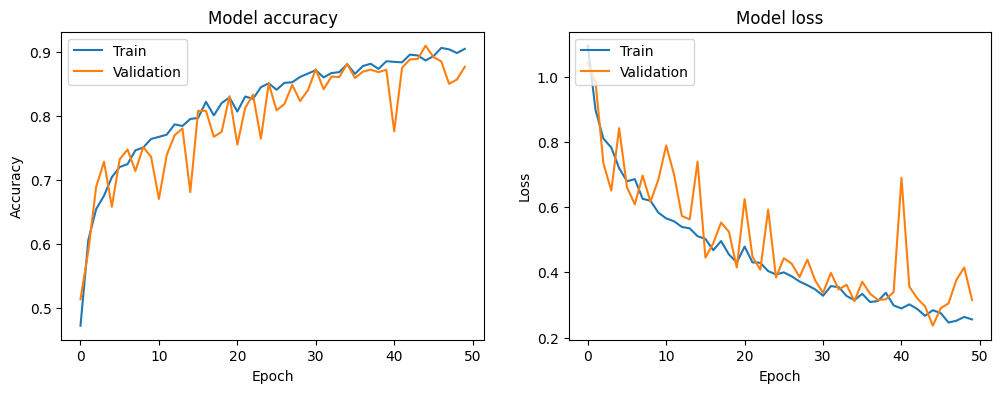

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.9174 - loss: 0.2435
Validation Loss: 0.2362
Validation Accuracy: 0.9092


In [77]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on validation data
evaluation = model.evaluate(val_generator)
print(f"Validation Loss: {evaluation[0]:.4f}")
print(f"Validation Accuracy: {evaluation[1]:.4f}")


In [79]:
model.export('brain_tumor_model')
!gsutil cp -r brain_tumor_model gs://rhic-innovation/models/


INFO:tensorflow:Assets written to: brain_tumor_model/assets


INFO:tensorflow:Assets written to: brain_tumor_model/assets


Saved artifact at 'brain_tumor_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name='keras_tensor_55')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139725044701088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139725044705312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139725044696864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139725044704080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139725044707952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139725044702496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139725044708128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139725044710064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139725044707072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139725044710944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1397250447

In [80]:
!gcloud ai models upload \
  --region=us-central1 \
  --display-name=brainT_model_v1 \
  --container-image-uri=us-docker.pkg.dev/vertex-ai/prediction/tf2-cpu.2-11:latest \
  --artifact-uri=gs://rhic-innovation/models/brain_tumor_model


Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [210996659327336448]...done.                             


In [81]:
!gcloud ai endpoints create \
  --region=us-central1 \
  --display-name=brainT_endpoint

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [4186267755411931136]...done.                            
Created Vertex AI endpoint: projects/257612295763/locations/us-central1/endpoints/5810194374633455616.


In [1]:
!gcloud ai models list --region=us-central1

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
MODEL_ID             DISPLAY_NAME
9195087100230238208  brainT_model_v1
7147075169683505152  brainT_model
5008076452915052544  brainT_model
211531743532941312   mnist_model
519465368054398976   mnist_model
4179926493897424896  retail_gemini_pro
1288615533125566464  retail_gemini_pro_v2


In [83]:
!gcloud ai endpoints deploy-model 5810194374633455616 \
  --display-name=brainT_modelv2 \
  --model=9195087100230238208  \
  --machine-type=n1-standard-4 \
  --traffic-split=0=100 \
  --region=us-central1

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Waiting for operation [6356158350874378240]...done.                            
Deployed a model to the endpoint 5810194374633455616. Id of the deployed model: 3479614552818057216.


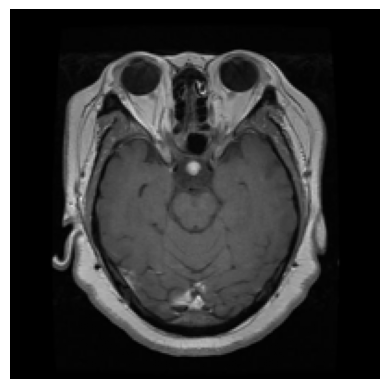

Image shape: (200, 200, 3)
Array type: float64


In [10]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
 
# Load the image
image = Image.open("test_data/Te-pi_0010.jpg")

# reshape image to 
image_resized = image.resize((img_height, img_width))

# Convert to NumPy array
image_array = np.array(image_resized)/255.

# Display the image using matplotlib
plt.imshow(image_array)
plt.axis("off")  # Hide axes
plt.show()

# Check array shape and type
print(f"Image shape: {image_array.shape}")
print(f"Array type: {image_array.dtype}")

In [11]:
from google.cloud import aiplatform

test_image = image_array.tolist() 
endpoint = aiplatform.Endpoint(
    endpoint_name="projects/rhic-innovation/locations/us-central1/endpoints/5810194374633455616"
)
response = endpoint.predict(instances=[test_image])
response

Prediction(predictions=[[0.000258102053, 0.012299424, 5.81127928e-08, 0.987442434]], deployed_model_id='3479614552818057216', metadata=None, model_version_id='1', model_resource_name='projects/257612295763/locations/us-central1/models/9195087100230238208', explanations=None)

In [13]:
class_labels = [label for label in val_generator.class_indices.keys()]
predictions = response[0][0]
predicted_class_idx = np.argmax(predictions)
predicted_label = class_labels[predicted_class_idx]

print(f"Predicted class: {predicted_label} (confidence: {np.max(predictions):.2%})")


Predicted class: pituitary (confidence: 98.74%)
